# External metrics for clustering

## Investigation of the external metrics for clustering in `river` and `sci-kit learn` when dealing with various ways of labelling

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import river
import scipy
import sklearn
import time

from sklearn import datasets

In regression, for example logistic regression, different labels (`0` or `1`) are considered as two totally different (positive or negative) results. However, in classification (especially in multilabel classification, when there is no positive label), we can regard these two labels as the same way of partitioning a dataset into different parts (since all of the elements in the same group originally have the same label).

As a result, this means that for example, if `[0,0,0,1,1,2]` is the true label and `[1,1,1,2,2,0]` is the predicted label, the F1-score must be equal to 1.

Moreover, if we assume that the predicted labels are `[0,0,1,1,2,2]` or `[2,2,0,0,1,1]` (which, once again, are the same way of partitioning the dataset into two parts), we expect that the F1-score of these two results are the same. We will investigate whether this is true below.

In [4]:
y0_true = [0,0,0,1,1,2]
y0_preds = [[1,1,1,2,2,0], 
            [0,0,1,1,2,2], 
            [2,2,0,0,1,1]]

In [6]:
for i in range(len(y0_preds)):
    print('Classification report for the prediction {}, using scikit-learn'.format(y0_preds[i]))
    print()
    print(sklearn.metrics.classification_report(y0_true, y0_preds[i]))
    print('Accuracy: {} %'.format(sklearn.metrics.accuracy_score(y0_true, y0_preds[i])*100))
    print()

Classification report for the prediction [1, 1, 1, 2, 2, 0], using scikit-learn

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         6
   macro avg       0.00      0.00      0.00         6
weighted avg       0.00      0.00      0.00         6

Accuracy: 0.0 %

Classification report for the prediction [0, 0, 1, 1, 2, 2], using scikit-learn

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.50      0.50      0.50         2
           2       0.50      1.00      0.67         1

   micro avg       0.67      0.67      0.67         6
   macro avg       0.67      0.72      0.66         6
weighted avg       0.75      0.67      0.68         6

Accuracy: 66.66666666666666 %

Classification report for th

In [8]:
for i in range(len(y0_preds)):
    metric = river.metrics.ClassificationReport()
    for j in range(len(y0_true)):
        metric = metric.update(y0_true[j], y0_preds[i][j])
    print('Classification report for the prediction {}, using incremental method from River'.format(y0_preds[i]))
    print()
    print(metric)
    print()

Classification report for the prediction [1, 1, 1, 2, 2, 0], using incremental method from River

           Precision   Recall   F1      Support  
                                                 
       0       0.000    0.000   0.000         3  
       1       0.000    0.000   0.000         2  
       2       0.000    0.000   0.000         1  
                                                 
   Macro       0.000    0.000   0.000            
   Micro       0.000    0.000   0.000            
Weighted       0.000    0.000   0.000            

                  0.0% accuracy                  

Classification report for the prediction [0, 0, 1, 1, 2, 2], using incremental method from River

           Precision   Recall   F1      Support  
                                                 
       0       1.000    0.667   0.800         3  
       1       0.500    0.500   0.500         2  
       2       0.500    1.000   0.667         1  
                                                 
  

As we can see, the result is not the same as what we have already expected. The F1-score between `[0,0,0,1,1,2]` and `[1,1,1,2,2,0]` is 0, which means that `sklearn` regards these two results totally different ways of partitioning the data. Besides, the F1-score between the true label and two results `[0,0,1,1,2,2]` or `[2,2,0,0,1,1]` are also different. 

This means that when the user wants to calculate the actual F1-score between the actual label and his/her predicted lables, he/she has to re-permutate the labels until getting the highest score.

From the examples above, we can draw the following conclusions:
* Both methods from two packages can not recognize the case when clustering lables are altered in order. As a result, when the maximum label is `n` and the clusters are labels `0, 1, 2, .., n-1`, whenever a clustering result is obtained, the user is suggest to try `n!` different permutations of the results in order to get the highest most accurate metrics.
* Both method yields the exact same result when `river` has finished iterating through all labels in the result. 
* While the `f1_score` function covers all kinds of F1 scores, including `micro`, `macro` and `weighted` through the `average` parameter, `river` separated these methods into `MicroF1()`, `MacroF1()` and `WeightedF1()`.

## Testing these metrics on a real clustering problem

In this section, the algorithms and metrics from both packages will be tested using an actual example. 

First, a dataset must be generated. In order to clearly define the clear true label of the clusters, we will use a the `make_blobs` function of the `datasets` module in `sci-kit learn`.  There will be `2000` samples which will be generatedm, while the number of clusters will be set to `4`, meaning that there will be `500` samples for each cluster. The number of features (dimension) would be `2`. For a clearer formation of the cluster, a standard deviation of `0.5` will be set for all clusters.

Using this dataset, we will compare two most foundational models of both packages, `KMeans`. 


In [30]:
n_samples = 2000
data, labels_true = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=4, cluster_std=0.5)

In [31]:
# fit the KMeans algorithm from sklearn and river onto the dataset, then retrieve the predicted label and cluster centers
# measure the time elapsed for each algorithm

start_KMeanssklearn = time.time()
KMeans_sklearn = sklearn.cluster.KMeans(n_clusters=4)
KMeans_sklearn.fit(data)
labels_pred_KMeanssklearn = KMeans_sklearn.predict(data)
end_KMeanssklearn = time.time()
cluster_centers_KMeanssklearn = KMeans_sklearn.cluster_centers_

start_KMeansriver = time.time()
KMeans_river = river.cluster.KMeans(n_clusters=4, halflife=0.4, sigma=1, seed=0)
labels_pred_KMeansriver = []
for i, (x, _) in enumerate(river.stream.iter_array(data)):
    KMeans_river = KMeans_river.learn_one(x)
    label_pred = KMeans_river.predict_one(x)
    labels_pred_KMeansriver.append(label_pred)
end_KMeansriver = time.time()
cluster_centers_KMeansriver = KMeans_river.centers

In [32]:
print("Classification report of KMeans from sklearn")
print(sklearn.metrics.classification_report(labels_true, labels_pred_KMeanssklearn))
print('Accuracy: {} %'.format(sklearn.metrics.accuracy_score(labels_true, labels_pred_KMeanssklearn)*100))
print("The time elapsed for KMeans from sklearn is {} seconds".format(end_KMeanssklearn - start_KMeanssklearn))
print()
print("Classification report of incremental KMeans from river")
print(sklearn.metrics.classification_report(labels_true, labels_pred_KMeansriver))
print('Accuracy: {} %'.format(sklearn.metrics.accuracy_score(labels_true, labels_pred_KMeansriver)*100))
print("The time elapsed for KMeans from sklearn is {} seconds".format(end_KMeansriver - start_KMeansriver))


Classification report of KMeans from sklearn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500

   micro avg       1.00      1.00      1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 100.0 %
The time elapsed for KMeans from sklearn is 0.03838324546813965 seconds

Classification report of incremental KMeans from river
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       0.00      0.00      0.00       500
           2       0.00      0.00      0.00       500
           3       1.00      1.00      1.00       500

   micro avg       0.50      0.50      0.50      2000
   macro avg       0.50      0.50      0.50     

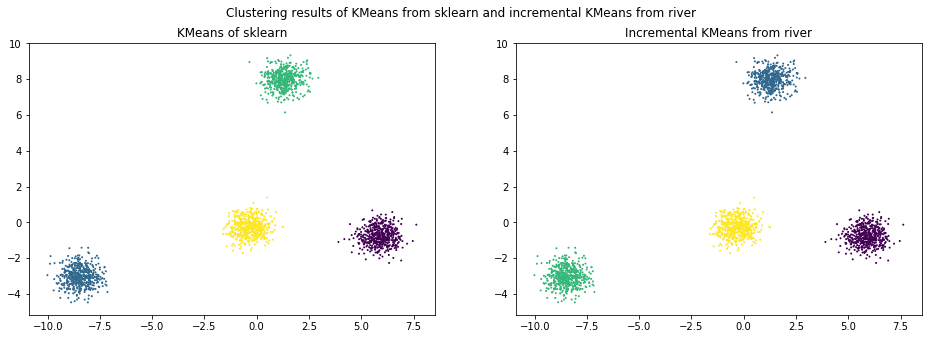

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,5))
fig.suptitle("Clustering results of KMeans from sklearn and incremental KMeans from river")

ax1.scatter(data[:,0], data[:,1], c=labels_pred_KMeanssklearn, s = 1)
ax1.title.set_text("KMeans of sklearn")

ax2.scatter(data[:,0], data[:,1], c=labels_pred_KMeansriver, s = 1)
ax2.title.set_text("Incremental KMeans from river")

plt.show()

First, we note that the KMeans algorithm in sklearn is much faster (~2 times) compared to our incremental KMeans. This may come from two following reasons:

* The programming language that the algorithm is implemented in.
* The fact that the incremental KMeans has to spend time learning each new instance when it is passed through.

Although the clusters generated can almost be identical to the true original result, the labels still have a high chance of being permuted. 

This problem can be fixed by choosing the most common predicted label among data points within the clusters of the true label, i.e the *mode*. This can be done using the `mode` function from `scipy.stats` module.

In essence, we are renaming the cluster, not re-clustering the data.

In [34]:
# find the permutation for the newly generated predicted labels
def find_permutation(n_clusters, true_labels, pred_labels):
    permutation=[]
    for i in range(n_clusters):
        idx = pred_labels == i
        new_label=scipy.stats.mode(true_labels[idx])[0][0]
        permutation.append(new_label)
    return permutation

In [35]:
# find the correct permutation and recalculate the labels for both KMneans and incremental Kmeans

permutation_KMeanssklearn = find_permutation(4, labels_true, np.array(labels_pred_KMeanssklearn))
new_labels_pred_KMeanssklearn = [ permutation_KMeanssklearn[label] for label in labels_pred_KMeanssklearn]

permutation_KMeansriver = find_permutation(4, labels_true, np.array(labels_pred_KMeansriver))
new_labels_pred_KMeansriver = [ permutation_KMeansriver[label] for label in labels_pred_KMeansriver]

In [36]:
print("New classification report of KMeans from sklearn")
print(sklearn.metrics.classification_report(labels_true, new_labels_pred_KMeanssklearn))
print('Accuracy: {} %'.format(sklearn.metrics.accuracy_score(labels_true, new_labels_pred_KMeanssklearn)*100))
print()
print("New classification report of incremental KMeans from river")
print(sklearn.metrics.classification_report(labels_true, new_labels_pred_KMeansriver))
print('Accuracy: {} %'.format(sklearn.metrics.accuracy_score(labels_true, new_labels_pred_KMeansriver)*100))


New classification report of KMeans from sklearn
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500

   micro avg       1.00      1.00      1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 100.0 %

New classification report of incremental KMeans from river
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500

   micro avg       1.00      1.00      1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Acc

From this result, we can say that the KMeans and incremental KMeans have roughly the same performance with neglectible difference.

Moreover, this result also somewhat means that users have to be very careful upon choosing to use the external incremental metrics for clustering, since it cannot catch the permutation of labels. A temporary solution is to permutate the labels each time a new instance is passed through, but it will then alter the labels of the previously passed instances, creating a more chaotic situation.

## Comparision between online clustering algorithms

This part of the notebook is denoted to compare the performance of two online clustering algorithm, `KMeans` and `CluStream`. These are two founding algorithm of online clustering, and through the implementation of `River`, they also have another similarity: `CluStream` uses the implemented incremental `KMeans` for its offline clustering phase. 

As a result, it is interesting to compare the performance between these two algorithms. To maintain fairness, all of the parameters implemented in `KMeans` will be the same when passing onto `CluStream`.

Moreover, as mentioned in the Docstring of `CluStream`, this algorithm has to be initiated by learning a certain nummber of points before predicting their labels. As a result, for the first run of this algorithm, it will be initiated by learning through 200 points before predicting all of the labels (since a smaller number of points will result in a `KeyError`).

In [40]:
start_CluStream = time.time()
CluStream = river.cluster.CluStream(time_window=1,
                                    max_micro_clusters=100,
                                    n_macro_clusters=4,
                                    halflife=0.4, 
                                    sigma=1, 
                                    seed=0)
labels_pred_CluStream = []

# let CluStream learn 200 first points
for x, _ in river.stream.iter_array(data[:200,:]):
    CluStream = CluStream.learn_one(x)

for i, (x, _) in enumerate(river.stream.iter_array(data)):
    label_pred = CluStream.predict_one(x)
    labels_pred_CluStream.append(label_pred)
end_CluStream = time.time()

In [41]:
permutation_CluStream = find_permutation(4, labels_true, np.array(labels_pred_CluStream))
new_labels_pred_CluStream = [ permutation_CluStream[label] for label in labels_pred_CluStream]

print("Classification report of CluStream")
print(sklearn.metrics.classification_report(labels_true, new_labels_pred_CluStream))
print('Accuracy: {} %'.format(sklearn.metrics.accuracy_score(labels_true, new_labels_pred_CluStream)*100))
print("The time elapsed for KMeans from sklearn is {} seconds".format(end_CluStream - start_CluStream))


Classification report of CluStream
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500

   micro avg       1.00      1.00      1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

Accuracy: 100.0 %
The time elapsed for KMeans from sklearn is 52.719465017318726 seconds


The performance of `CluStream` in this case is as effective as the two algorithms mentioned above; however, it is much more time-consuming than the normal and incremental KMeans. In our experiment, `CluStream` is ~750 times slower than the original incremental `KMeans`. 

This can easily be explained by that for each instance that is passed through, the incremental KMeans will be called and run once to general the desired number of clusters, making the elapsed time much longer.